In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import os
import requests
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split
#from google.colab import files
from IPython.display import display, HTML, Image
import imageio.v2 as imageio
from tqdm import tqdm

apple.ndjson already exists
eye.ndjson already exists
square.ndjson already exists
triangle.ndjson already exists
circle.ndjson already exists
pear.ndjson already exists
hand.ndjson already exists
car.ndjson already exists
Loading apple...
  Loaded 100000 samples
Loading eye...
  Loaded 100000 samples
Loading square...
  Loaded 100000 samples
Loading triangle...
  Loaded 100000 samples
Loading circle...
  Loaded 100000 samples
Loading pear...
  Loaded 100000 samples
Loading hand...
  Loaded 100000 samples
Loading car...
  Loaded 100000 samples

Samples -> Train: 576000, Val: 64000, Test: 160000


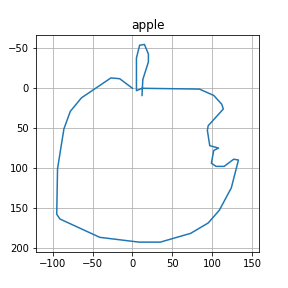

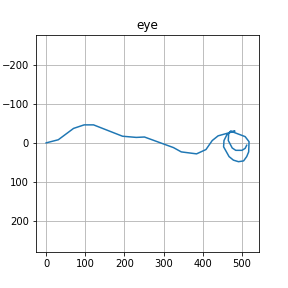

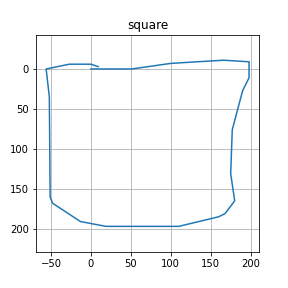

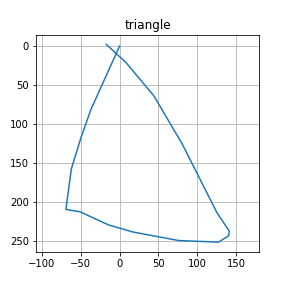

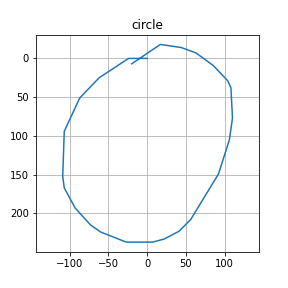

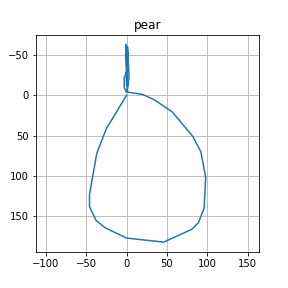

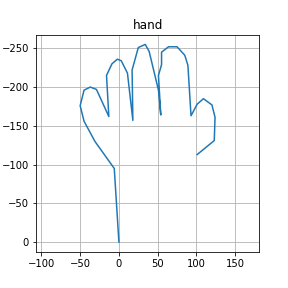

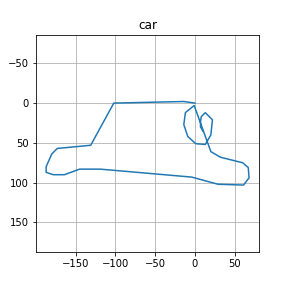

In [2]:
import torch
import numpy as np
import json
import os
import requests
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from IPython.display import Image, display
from collections import defaultdict

# =======================
# Device
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =======================
# Hyperparameters
# =======================
NUM_CLASSES = 8
STROKE_DIM = 2          # we will ignore pen_state later
MAX_SEQ_LEN = 16
BATCH_SIZE = 64
SAMPLES_PER_CLASS = 100000

CLASSES = ["apple", "eye", "square", "triangle", "circle", "pear", "hand", "car"]

# =======================
# Download QuickDraw
# =======================
def download_quickdraw_data(data_dir="quickdraw_data"):
    os.makedirs(data_dir, exist_ok=True)
    for cls in CLASSES:
        path = os.path.join(data_dir, f"{cls}.ndjson")
        url = f"https://storage.googleapis.com/quickdraw_dataset/full/simplified/{cls}.ndjson"

        if not os.path.exists(path):
            print(f"Downloading {cls}...")
            r = requests.get(url, stream=True)
            r.raise_for_status()
            with open(path, "wb") as f:
                for chunk in r.iter_content(8192):
                    f.write(chunk)
        else:
            print(f"{cls}.ndjson already exists")

# =======================
# Dataset
# =======================
class QuickDrawDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        class_idx, strokes = self.data[idx]

        one_hot = torch.zeros(NUM_CLASSES)
        one_hot[class_idx] = 1.0

        strokes = np.array(strokes)[:, :2]  # keep Δx, Δy only

        if len(strokes) > MAX_SEQ_LEN:
            strokes = strokes[:MAX_SEQ_LEN]
        else:
            pad = np.zeros((MAX_SEQ_LEN - len(strokes), STROKE_DIM))
            strokes = np.vstack([strokes, pad])

        return one_hot, torch.tensor(strokes, dtype=torch.float32)

# =======================
# Load & Filter Data
# =======================
def load_quickdraw_data(data_dir="quickdraw_data"):
    data = []
    class_to_idx = {cls: i for i, cls in enumerate(CLASSES)}
    class_counts = defaultdict(int)

    for cls in CLASSES:
        file_path = os.path.join(data_dir, f"{cls}.ndjson")
        print(f"Loading {cls}...")

        with open(file_path, "r") as f:
            for line in f:
                if class_counts[cls] >= SAMPLES_PER_CLASS:
                    break

                drawing = json.loads(line)

                # ✅ ONLY recognized sketches
                if not drawing.get("recognized", False):
                    continue

                processed = []
                for stroke in drawing["drawing"]:
                    x, y = stroke[0], stroke[1]
                    for i in range(len(x) - 1):
                        dx = x[i + 1] - x[i]
                        dy = y[i + 1] - y[i]
                        processed.append([dx, dy])

                if len(processed) > 1:
                    data.append((class_to_idx[cls], processed))
                    class_counts[cls] += 1

        print(f"  Loaded {class_counts[cls]} samples")

    return data

# =======================
# Train / Val / Test Split
# =======================
def split_data_by_class(data, train_ratio=0.8, val_ratio=0.1):
    classwise = defaultdict(list)
    for cls, strokes in data:
        classwise[cls].append((cls, strokes))

    train, val, test = [], [], []

    for cls, samples in classwise.items():
        np.random.shuffle(samples)
        n = len(samples)

        train_end = int(n * train_ratio)
        val_end = int(train_end * val_ratio)

        val.extend(samples[:val_end])
        train.extend(samples[val_end:train_end])
        test.extend(samples[train_end:])

    return train, val, test

# =======================
# Balanced Sampler
# =======================
def make_balanced_sampler(data):
    class_counts = defaultdict(int)
    for cls, _ in data:
        class_counts[cls] += 1

    weights = [1.0 / class_counts[cls] for cls, _ in data]

    return WeightedRandomSampler(
        weights=torch.DoubleTensor(weights),
        num_samples=len(weights),
        replacement=True
    )

# =======================
# DataLoaders
# =======================
def prepare_data_loaders(batch_size=BATCH_SIZE, num_workers=4):
    train_data, val_data, test_data = split_data_by_class(data)

    train_dataset = QuickDrawDataset(train_data)
    val_dataset = QuickDrawDataset(val_data)
    test_dataset = QuickDrawDataset(test_data)

    train_sampler = make_balanced_sampler(train_data)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,   # ✅ balanced batches
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print(
        f"\nSamples -> Train: {len(train_dataset)}, "
        f"Val: {len(val_dataset)}, Test: {len(test_dataset)}"
    )

    return train_loader, val_loader, test_loader

# =======================
# Visualization (Optional)
# =======================
def visualize_raw_data(data, save_dir="raw_vis"):
    os.makedirs(save_dir, exist_ok=True)

    shown = {}
    for cls, strokes in data:
        if cls in shown:
            continue
        shown[cls] = strokes
        if len(shown) == NUM_CLASSES:
            break

    for cls, strokes in shown.items():
        x, y = 0, 0
        xs, ys = [0], [0]

        for dx, dy in strokes:
            x += dx
            y += dy
            xs.append(x)
            ys.append(y)

        plt.figure(figsize=(4, 4))
        plt.plot(xs, ys)
        plt.gca().invert_yaxis()
        plt.title(CLASSES[cls])
        plt.axis("equal")
        plt.grid()

        path = os.path.join(save_dir, f"{CLASSES[cls]}.png")
        plt.savefig(path)
        plt.close()
        display(Image(filename=path))

# =======================
# Main
# =======================
if __name__ == "__main__":
    download_quickdraw_data()
    data = load_quickdraw_data()
    train_loader, val_loader, test_loader = prepare_data_loaders()
    visualize_raw_data(data)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

# Hyperparameters
NUM_CLASSES = 8
HIDDEN_SIZE = 128
NUM_LAYERS = 4
EMBEDDING_DIM = 64
STROKE_DIM = 2  # Changed to 2 to predict only delta_x and delta_y
DROPOUT = 0.4
LEARNING_RATE = 0.005
WEIGHT_DECAY = 1e-5
MAX_SEQ_LEN = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LSTM-based Generator Model
class SketchGenerator(nn.Module):
    def __init__(self, num_classes, embedding_dim, hidden_size, num_layers, stroke_dim):
        super(SketchGenerator, self).__init__()
        self.linear_in = nn.Linear(num_classes, embedding_dim)
        nn.init.xavier_uniform_(self.linear_in.weight)
        # Input to LSTM: class embedding + stroke coordinates (delta_x, delta_y)
        self.lstm = nn.LSTM(embedding_dim + stroke_dim, hidden_size, num_layers,
                            batch_first=True, dropout=DROPOUT)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(hidden_size, stroke_dim)  # Output only delta_x, delta_y
        nn.init.xavier_uniform_(self.fc.weight)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, class_one_hot, strokes, hidden=None):
        batch_size = class_one_hot.size(0)
        seq_len = strokes.size(1) if strokes is not None else MAX_SEQ_LEN
        class_embed = self.linear_in(class_one_hot).unsqueeze(1).repeat(1, seq_len, 1)
        inputs = torch.cat((class_embed, strokes), dim=2) if strokes is not None else class_embed
        if hidden is None:
            hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                      torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        out, hidden = self.lstm(inputs, hidden)
        out = self.dropout(out)
        out = self.fc(out)  # Outputs [batch_size, seq_len, 2] for delta_x, delta_y
        return out, hidden

# Initialize model, optimizer, scheduler
def initialize_training_components():
    model = SketchGenerator(NUM_CLASSES, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS, STROKE_DIM).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
    return model, optimizer, scheduler

# Display model summary
def display_model_summary(model, batch_size=64):
    print("\nModel Summary:")
    summary(model, input_data=[
        torch.zeros(batch_size, NUM_CLASSES).to(device),
        torch.zeros(batch_size, MAX_SEQ_LEN - 1, STROKE_DIM).to(device)  # STROKE_DIM=2
    ], verbose=1)

# Main execution (only model + data loader)
if __name__ == "__main__":
    try:
        from data_loader import prepare_data_loaders
        print("Data loader found, loading sample data...")
        train_loader, _, _ = prepare_data_loaders()
        model, _, _ = initialize_training_components()
        display_model_summary(model)
    except ImportError:
        print("Data loader not found, displaying model summary with default batch size...")
        model, _, _ = initialize_training_components()
        display_model_summary(model)

Data loader not found, displaying model summary with default batch size...

Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
SketchGenerator                          [64, 63, 2]               --
├─Linear: 1-1                            [64, 64]                  576
├─LSTM: 1-2                              [64, 63, 128]             496,640
├─Dropout: 1-3                           [64, 63, 128]             --
├─Linear: 1-4                            [64, 63, 2]               258
Total params: 497,474
Trainable params: 497,474
Non-trainable params: 0
Total mult-adds (G): 2.00
Input size (MB): 0.03
Forward/backward pass size (MB): 4.23
Params size (MB): 1.99
Estimated Total Size (MB): 6.25


In [4]:
#!pip install torchinfo

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=200,
    lr=0.005,
    model_save_path="sketchgen_best_model.pth"
):
    # ---- Loss & Optimizer ----
    criterion = nn.SmoothL1Loss(reduction="none")  # Huber loss

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=0.0
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        patience=3,
        factor=0.5,
        verbose=True
    )

    best_balanced_val_loss = float("inf")
    last_model_path = os.path.join(
        os.path.dirname(model_save_path),
        "sketchgen_last_model.pth"
    )

    model.to(device)

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

        # ===============================
        # TRAINING
        # ===============================
        model.train()
        train_loss_sum = 0.0

        for labels, strokes in tqdm(train_loader, desc="Training", leave=False):
            labels = labels.to(device)
            strokes = strokes.to(device)

            strokes_xy = strokes[:, :, :2]
            inputs = strokes_xy[:, :-1]
            targets = strokes_xy[:, 1:]

            optimizer.zero_grad()

            outputs, _ = model(labels, inputs)

            loss_tensor = criterion(outputs, targets)
            loss = loss_tensor.mean()          # 🔑 scalar loss
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss_sum += loss.item()

        avg_train_loss = train_loss_sum / len(train_loader)
        print(f"Train Loss: {avg_train_loss:.4f}")

        # ===============================
        # VALIDATION (CLASS-BALANCED)
        # ===============================
        model.eval()
        class_loss_sum = defaultdict(float)
        class_count = defaultdict(int)

        with torch.no_grad():
            for labels, strokes in tqdm(val_loader, desc="Validation", leave=False):
                labels = labels.to(device)
                strokes = strokes.to(device)

                strokes_xy = strokes[:, :, :2]
                inputs = strokes_xy[:, :-1]
                targets = strokes_xy[:, 1:]

                outputs, _ = model(labels, inputs)

                loss_tensor = criterion(outputs, targets)
                per_sample_loss = loss_tensor.mean(dim=(1, 2))

                class_indices = labels.argmax(dim=1)

                for i, cls_idx in enumerate(class_indices):
                    cls = cls_idx.item()
                    class_loss_sum[cls] += per_sample_loss[i].item()
                    class_count[cls] += 1

        avg_class_losses = {
            cls: class_loss_sum[cls] / class_count[cls]
            for cls in class_loss_sum
        }

        balanced_val_loss = sum(avg_class_losses.values()) / len(avg_class_losses)
        print(f"Val Loss (class-balanced avg): {balanced_val_loss:.4f}")

        # ✅ USE THE LR SCHEDULER HERE
        scheduler.step(balanced_val_loss)

        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Current LR: {current_lr:.6f}")

        # ===============================
        # SAVE BEST / LAST MODEL
        # ===============================
        if balanced_val_loss < best_balanced_val_loss:
            best_balanced_val_loss = balanced_val_loss
            torch.save(model.state_dict(), model_save_path)
            print("✅ Saved BEST model")

        if epoch == num_epochs - 1:
            torch.save(model.state_dict(), last_model_path)
            print("📌 Saved LAST model")
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=100,
    lr=LEARNING_RATE,
    model_save_path="sketchgen_best_model.pth"
)


Epoch [1/100]


Train Loss: 4.7131


Val Loss (class-balanced avg): 4.4058
Current LR: 0.005000
✅ Saved BEST model

Epoch [2/100]


Train Loss: 4.6260


Val Loss (class-balanced avg): 4.4005
Current LR: 0.005000
✅ Saved BEST model

Epoch [3/100]


Train Loss: 4.6276


Val Loss (class-balanced avg): 4.3990
Current LR: 0.005000
✅ Saved BEST model

Epoch [4/100]


Train Loss: 4.6350


Val Loss (class-balanced avg): 4.4004
Current LR: 0.005000

Epoch [5/100]


Train Loss: 4.6484


Val Loss (class-balanced avg): 4.4091
Current LR: 0.005000

Epoch [6/100]


Train Loss: 4.6647


Val Loss (class-balanced avg): 4.4256
Current LR: 0.005000

Epoch [7/100]


Train Loss: 4.6832


Val Loss (class-balanced avg): 4.4257
Epoch 00007: reducing learning rate of group 0 to 2.5000e-03.
Current LR: 0.002500

Epoch [8/100]


Train Loss: 4.6253


Val Loss (class-balanced avg): 4.3783
Current LR: 0.002500
✅ Saved BEST model

Epoch [9/100]


Train Loss: 4.6013


Val Loss (class-balanced avg): 4.3650
Current LR: 0.002500
✅ Saved BEST model

Epoch [10/100]


Training:  13%|████████████████▊                                                                                                             | 1201/9000 [00:12<01:41, 76.61it/s]

In [ ]:
# ============================================================
# Inference: Class → Sketch GIF
# ============================================================
def generate_sketch_from_class(model, class_name, device, output_dir="generated_results"):
    if class_name not in CLASSES:
        print(f"❌ Invalid class. Choose from {CLASSES}")
        return

    os.makedirs(output_dir, exist_ok=True)
    model.eval()

    cls_idx = CLASSES.index(class_name)
    class_one_hot = torch.zeros(1, NUM_CLASSES).to(device)
    class_one_hot[0, cls_idx] = 1.0

    prev_stroke = torch.zeros(1, 1, STROKE_DIM).to(device)
    hidden = None
    generated = []

    with torch.no_grad():
        for _ in range(MAX_SEQ_LEN):
            out, hidden = model(class_one_hot, prev_stroke, hidden)
            delta = out[:, -1, :]
            generated.append(delta.squeeze(0).cpu().numpy())
            prev_stroke = delta.unsqueeze(1)

    save_generated_gif(np.array(generated), class_name, output_dir)

def save_generated_gif(strokes, class_name, output_dir):
    x, y = 0.0, 0.0
    coords = [(x, y)]

    for dx, dy in strokes:
        x += dx
        y += dy
        coords.append((x, y))

    xs = [p[0] for p in coords]
    ys = [p[1] for p in coords]
    margin = 0.1 * max(max(xs) - min(xs), max(ys) - min(ys), 1)

    frames = []
    fig, ax = plt.subplots(figsize=(5, 5))

    for i in range(1, len(coords)):
        ax.clear()
        ax.set_title(f"Generated Sketch: {class_name}")
        ax.invert_yaxis()
        ax.grid(True)
        ax.set_xlim(min(xs) - margin, max(xs) + margin)
        ax.set_ylim(min(ys) - margin, max(ys) + margin)

        for j in range(i):
            x1, y1 = coords[j]
            x2, y2 = coords[j + 1]
            ax.plot([x1, x2], [y1, y2], "b-")

        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)

    gif_path = os.path.join(output_dir, f"{class_name}.gif")
    imageio.mimsave(gif_path, frames, fps=10)
    plt.close(fig)

    print(f"🎨 Generated sketch saved → {gif_path}")

def generate_all_class_comparison_gifs(
    model,
    test_loader,
    device,
    output_dir="all_class_comparisons"
):
    """
    Generates one GIF per class showing:
    LEFT  -> Actual (GT) sketch
    RIGHT -> Predicted (Generated) sketch
    """
    os.makedirs(output_dir, exist_ok=True)
    model.eval()

    # ------------------------------------------------
    # Step 1: pick ONE GT sample per class
    # ------------------------------------------------
    gt_samples = {}

    for labels, strokes in test_loader:
        labels = labels.to(device)
        strokes = strokes.to(device)

        class_indices = labels.argmax(dim=1)
        for i, cls_idx in enumerate(class_indices):
            cls = cls_idx.item()
            if cls not in gt_samples:
                gt_samples[cls] = strokes[i].cpu().numpy()[:, :2]
            if len(gt_samples) == NUM_CLASSES:
                break
        if len(gt_samples) == NUM_CLASSES:
            break

    # ------------------------------------------------
    # Step 2: generate prediction + GIF per class
    # ------------------------------------------------
    for cls_idx in range(NUM_CLASSES):
        class_name = CLASSES[cls_idx]
        print(f"Generating comparison GIF for class: {class_name}")

        # ---- Autoregressive prediction ----
        class_one_hot = torch.zeros(1, NUM_CLASSES).to(device)
        class_one_hot[0, cls_idx] = 1.0

        prev_stroke = torch.zeros(1, 1, STROKE_DIM).to(device)
        hidden = None
        generated = []

        with torch.no_grad():
            for _ in range(MAX_SEQ_LEN):
                out, hidden = model(class_one_hot, prev_stroke, hidden)
                delta = out[:, -1, :]
                generated.append(delta.squeeze(0).cpu().numpy())
                prev_stroke = delta.unsqueeze(1)

        generated = np.array(generated)
        actual = gt_samples[cls_idx]

        # ---- Create GIF ----
        save_actual_vs_predicted_gif(
            actual_strokes=actual,
            predicted_strokes=generated,
            class_name=class_name,
            output_dir=output_dir
        )
def save_actual_vs_predicted_gif(
    actual_strokes,
    predicted_strokes,
    class_name,
    output_dir
):
    """
    Creates a side-by-side GIF:
    LEFT  -> actual sketch
    RIGHT -> predicted sketch
    """
    def reconstruct(strokes):
        x, y = 0.0, 0.0
        coords = [(x, y)]
        for dx, dy in strokes:
            x += dx
            y += dy
            coords.append((x, y))
        return coords

    actual_coords = reconstruct(actual_strokes)
    pred_coords = reconstruct(predicted_strokes)

    all_x = [p[0] for p in actual_coords + pred_coords]
    all_y = [p[1] for p in actual_coords + pred_coords]
    margin = 0.1 * max(max(all_x) - min(all_x), max(all_y) - min(all_y), 1)

    frames = []
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Actual vs Predicted: {class_name}")

    max_len = min(len(actual_coords), len(pred_coords))

    for i in range(1, max_len):
        ax1.clear()
        ax2.clear()

        for ax, title in zip([ax1, ax2], ["Actual Sketch", "Predicted Sketch"]):
            ax.set_title(title)
            ax.invert_yaxis()
            ax.grid(True)
            ax.set_xlim(min(all_x) - margin, max(all_x) + margin)
            ax.set_ylim(min(all_y) - margin, max(all_y) + margin)

        # ---- Actual ----
        for j in range(i):
            x1, y1 = actual_coords[j]
            x2, y2 = actual_coords[j + 1]
            ax1.plot([x1, x2], [y1, y2], "g-")

        # ---- Predicted ----
        for j in range(i):
            x1, y1 = pred_coords[j]
            x2, y2 = pred_coords[j + 1]
            ax2.plot([x1, x2], [y1, y2], "b-")

        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)

    gif_path = os.path.join(output_dir, f"{class_name}_actual_vs_pred.gif")
    imageio.mimsave(gif_path, frames, fps=10)
    plt.close(fig)

    print(f"Saved → {gif_path}")

In [ ]:
# ============================================================
# MAIN
# ============================================================
if __name__ == "__main__":

    # ⬇️ Your existing dataloader function
    train_loader, val_loader, _ = prepare_data_loaders()

    model = SketchGenerator(
        NUM_CLASSES,
        EMBEDDING_DIM,
        HIDDEN_SIZE,
        NUM_LAYERS,
        STROKE_DIM
    ).to(device)

    generate_all_class_comparison_gifs(
    model=model,
    test_loader=test_loader,
    device=device,
    output_dir="all_class_results"
)

#     # ===============================
#     # INTERACTIVE INFERENCE
#     # ===============================
#     while True:
#         user_input = input("\nEnter class name to draw (or 'exit'): ").strip().lower()
#         if user_input == "exit":
#             break

# #         generate_sketch_from_class(model, user_input, device)